# Classifiez automatiquement des biens de consommation : 
*Notebook mission 1 - techniques traitement d'images*

**Etudiez la faisabilité d'un moteur de classification d'articles**

Vous êtes Data Scientist au sein de l’entreprise "Place de marché”, qui souhaite lancer une marketplace e-commerce. Sur cette place de marché anglophone, des vendeurs proposent des articles à des acheteurs en postant une photo et une description.

Pour l'instant, l'attribution de la catégorie d'un article est effectuée manuellement par les vendeurs, et est donc peu fiable. De plus, le volume des articles est pour l’instant très petit.
 

Pour rendre l’expérience utilisateur des vendeurs (faciliter la mise en ligne de nouveaux articles) et des acheteurs (faciliter la recherche de produits) la plus fluide possible, et dans l'optique d'un passage à l'échelle,  il devient nécessaire d'automatiser cette tâche d‘attribution de la catégo

Objectif : Etudier la faisabilité d'un moteur de classification des articles en différentes catégories, à partir du texte (en anglais) et de l’image comme dans l’illustration ci-dessous.rie.

**3 et 4 parties de la mission :**

Faisabilité de classification - techniques traitement d'images basiques

- Analysez les images via différentes méthodes de transformation (niveau de gris, filtrage bruit, contraste etc.).
- Utilisez des algorithmes d'extraction d'e features d’images comme SIFT.
- Utilisez des méthodes de réduction de dimension sur les images encodées et comparer les résultats avec les catégories réelles. 

Faisabilité de classification - techniques traitement d'images plus avancées

- Reprenez la démarche précédente en utilisant cette fois-ci des réseaux de neurones pré-entraînés. 
- Comparez vos résultats avec ceux des méthodes de traitement d’image plus basiques.

In [2]:
# fonctions personnelles pour le pré traitement des données textuelles
import pre_treatment_text as ptt

import numpy as np

import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import ScalarFormatter
from matplotlib.ticker import FuncFormatter
import scipy
from scipy import stats
import scipy.stats as st

import statsmodels
import statsmodels.api as sm

import sklearn

# pour le centrage et la réduction
from sklearn.preprocessing import StandardScaler, MinMaxScaler
# pour l'ACP
from sklearn.decomposition import PCA

from sklearn import metrics
from sklearn.metrics import roc_curve, auc, confusion_matrix

from sklearn.cluster import KMeans

from sklearn.manifold import TSNE

import timeit
import time

from collections import defaultdict
from collections import Counter

import PIL
from PIL import Image
from PIL import ImageEnhance, ImageOps, ImageFilter

import cv2

print("numpy version", np.__version__)
print("pandas version", pd.__version__)
print("matplotlib version", matplotlib.__version__)
print("seaborn version", sns.__version__)
print("scipy version", scipy.__version__)
print("statsmodels version", statsmodels.__version__)

print("sklearn version", sklearn.__version__)

print("PIL version", PIL.__version__)
print("cv2 version", cv2.__version__)

pd.options.display.max_rows = 200
pd.options.display.max_columns = 100

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\admin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\admin\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\admin\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


numpy version 1.26.4
pandas version 2.1.4
matplotlib version 3.8.0
seaborn version 0.13.2
scipy version 1.11.4
statsmodels version 0.14.0
sklearn version 1.6.1
PIL version 10.2.0
cv2 version 4.11.0


## 1 - Pré traitement du dataset

**Chargement des données**

In [4]:
# Charger le fichier de données
data = pd.read_csv("C:/Users/admin/Documents/Projets/Projet_6/data_projet/Dataset+projet+prétraitement+textes+images/Flipkart/flipkart_com-ecommerce_sample_1050.csv", \
                   sep=',', low_memory=False)
data.head()

,uniq_id,crawl_timestamp,product_url,product_name,product_category_tree,pid,retail_price,discounted_price,image,is_FK_Advantage_product,description,product_rating,overall_rating,brand,product_specifications
0,55b85ea15a1536d46b7190ad6fff8ce7,2016-04-30 03:22:56 +0000,http://www.flipkart.com/elegance-polyester-mul...,Elegance Polyester Multicolor Abstract Eyelet ...,"[""Home Furnishing >> Curtains & Accessories >>...",CRNEG7BKMFFYHQ8Z,1899.0,899.0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,False,Key Features of Elegance Polyester Multicolor ...,No rating available,No rating available,Elegance,"{""product_specification""=>[{""key""=>""Brand"", ""v..."
1,7b72c92c2f6c40268628ec5f14c6d590,2016-04-30 03:22:56 +0000,http://www.flipkart.com/sathiyas-cotton-bath-t...,Sathiyas Cotton Bath Towel,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEGFZHGBXPHZUH,600.0,449.0,7b72c92c2f6c40268628ec5f14c6d590.jpg,False,Specifications of Sathiyas Cotton Bath Towel (...,No rating available,No rating available,Sathiyas,"{""product_specification""=>[{""key""=>""Machine Wa..."
2,64d5d4a258243731dc7bbb1eef49ad74,2016-04-30 03:22:56 +0000,http://www.flipkart.com/eurospa-cotton-terry-f...,Eurospa Cotton Terry Face Towel Set,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEG6SHXTDB2A2Y,NaN,NaN,64d5d4a258243731dc7bbb1eef49ad74.jpg,False,Key Features of Eurospa Cotton Terry Face Towe...,No rating available,No rating available,Eurospa,"{""product_specification""=>[{""key""=>""Material"",..."
3,d4684dcdc759dd9cdf41504698d737d8,2016-06-20 08:49:52 +0000,http://www.flipkart.com/santosh-royal-fashion-...,SANTOSH ROYAL FASHION Cotton Printed King size...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",BDSEJT9UQWHDUBH4,2699.0,1299.0,d4684dcdc759dd9cdf41504698d737d8.jpg,False,Key Features of SANTOSH ROYAL FASHION Cotton P...,No rating available,No rating available,SANTOSH ROYAL FASHION,"{""product_specification""=>[{""key""=>""Brand"", ""v..."
4,6325b6870c54cd47be6ebfbffa620ec7,2016-06-20 08:49:52 +0000,http://www.flipkart.com/jaipur-print-cotton-fl...,Jaipur Print Cotton Floral King sized Double B...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",BDSEJTHNGWVGWWQU,2599.0,698.0,6325b6870c54cd47be6ebfbffa620ec7.jpg,False,Key Features of Jaipur Print Cotton Floral Kin...,No rating available,No rating available,Jaipur Print,"{""product_specification""=>[{""key""=>""Machine Wa..."


Dans ce dataset, nous utiliserons uniquement les noms des produits (product_name), les catégories de premier niveau (transformation de product_category_tree), les noms des fichiers d'image (image).

**Préparation de la variable catégorielle cible**

Transformons la catégorie pour conserver uniquement le 1er niveau :

In [6]:
y = data['product_category_tree']
y

0       ["Home Furnishing >> Curtains & Accessories >>...
1       ["Baby Care >> Baby Bath & Skin >> Baby Bath T...
2       ["Baby Care >> Baby Bath & Skin >> Baby Bath T...
3       ["Home Furnishing >> Bed Linen >> Bedsheets >>...
4       ["Home Furnishing >> Bed Linen >> Bedsheets >>...
                              ...                        
1045    ["Baby Care >> Baby & Kids Gifts >> Stickers >...
1046    ["Baby Care >> Baby & Kids Gifts >> Stickers >...
1047    ["Baby Care >> Baby & Kids Gifts >> Stickers >...
1048    ["Baby Care >> Baby & Kids Gifts >> Stickers >...
1049    ["Baby Care >> Baby & Kids Gifts >> Stickers >...
Name: product_category_tree, Length: 1050, dtype: object

In [7]:
# Appliquer la méthode split sur chaque élément de la colonne
y = data['product_category_tree'].apply(lambda x: ptt.clean_category_first_level(x))
y

0       Home Furnishing
1             Baby Care
2             Baby Care
3       Home Furnishing
4       Home Furnishing
             ...       
1045          Baby Care
1046          Baby Care
1047          Baby Care
1048          Baby Care
1049          Baby Care
Name: product_category_tree, Length: 1050, dtype: object

## 2 - Analyse d'une image

### 2.1 - Premières manipulations

In [9]:
# Charger l'image
img = Image.open("C:/Users/admin/Documents/Projets/Projet_6/data_projet/Dataset+projet+prétraitement+textes+images/Flipkart/Images/b6c339777814451815fe7950fd4c8536.jpg") 

# Afficher l'image chargée
img.show()

**Quelle est la taille de notre image, donnée en nombre de pixels :**

In [11]:
# Récupérer et afficher la taille de l'image (en pixels)
w, h = img.size
print("Largeur : {} px, hauteur : {} px".format(w, h))

Largeur : 1100 px, hauteur : 734 px


**Regardons les valeurs des pixels**

In [13]:
# Afficher son mode de quantification
print("Format des pixels : {}".format(img.mode))

# Récupérer et afficher la valeur du pixel à une position précise
px_value = img.getpixel((20,100))
print("Valeur du pixel situé en (20,100) : {}".format(px_value))

Format des pixels : RGB
Valeur du pixel situé en (20,100) : (220, 221, 216)


Le format utilisé est RGB pour une photo en couleur (3x8-bit pixels, true color - Rouge-vert-bleu).

Nous pouvons récupérer d'un seul coup les valeurs de tous les pixels de l'image à l'aide de la bibliothèque numpy :

In [15]:
# Récupérer les valeurs de tous les pixels sous forme d'une matrice
mat = np.array(img)
mat

# Afficher la taille de la matrice de pixels
print("Taille de la matrice de pixels : {}".format(mat.shape))

Taille de la matrice de pixels : (734, 1100, 3)


Matrice à 3 dimensions pour les valeurs de R, G, B

**Convertissons l'image en niveau de gris**

In [18]:
img = img.convert("L")

In [19]:
# Afficher son mode de quantification
print("Format des pixels : {}".format(img.mode))

# Récupérer et afficher la valeur du pixel à une position précise
px_value = img.getpixel((20,100))
print("Valeur du pixel situé en (20,100) : {}".format(px_value))

Format des pixels : L
Valeur du pixel situé en (20,100) : 220


In [20]:
# Récupérer les valeurs de tous les pixels sous forme d'une matrice
mat = np.array(img)

# Afficher la taille de la matrice de pixels
print("Taille de la matrice de pixels : {}".format(mat.shape))

Taille de la matrice de pixels : (734, 1100)


En niveau de gris, on se retrouve avec une matrice en 2 dimensions.

### 2.2 - Manipulations d'histogrammes

**Histogramme de l'image non modifiée**

On part de la matrice "mat" généré via numpy à partir de l'objet Image.

In [23]:
# Fonction commune pour afficher l'histogramme
def display_histo_intensity(matrice, title):
    # Générer et afficher l'histogramme
    # Pour le normaliser : argument density=True dans plt.hist
    # Pour avoir l'histogramme cumulé : argument cumulative=True
    n, bins, patches = plt.hist(matrice.flatten(), bins=range(256))
    
    # Ajouter des labels pour les axes
    plt.xlabel("Intensité des pixels - niveau de gris")  # Label pour l'axe X
    plt.ylabel("nombre de pixels")                       # Label pour l'axe Y
    
    # Titre de l'histogramme (optionnel)
    plt.title(title)

    # Afficher l'histogramme
    plt.show()

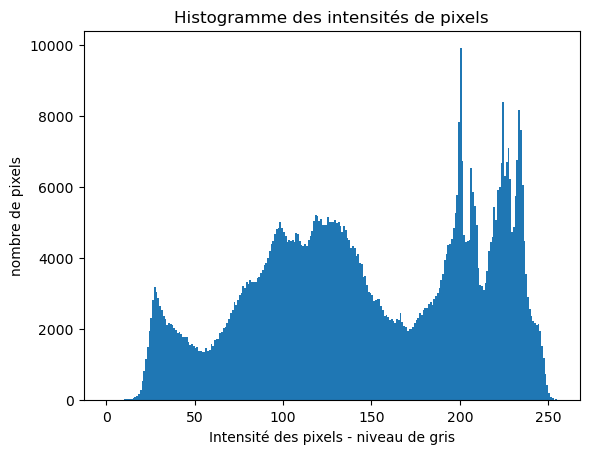

In [24]:
display_histo_intensity(mat, "Histogramme des intensités de pixels")

- 0 : noir
- 250 : blanc

On voit que l'intensité assez bien réparties.

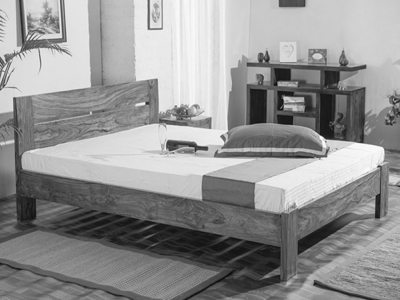

In [26]:
# Redimensionner l'image pour l'affichage
img_resized = img.resize((400, 300))  # Spécifiez la largeur et la hauteur
img_resized

**Correction de l'exposition**

Une première application consiste à corriger la luminosité, ou exposition, de l'image.

Image sous-exposée :

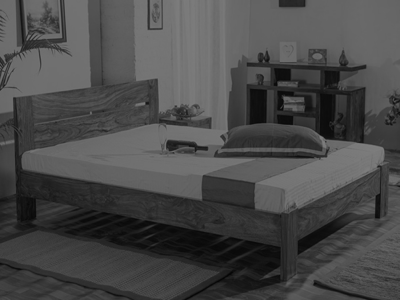

In [28]:
# Créer un objet ImageEnhance pour la luminosité
enhancer = ImageEnhance.Brightness(img)

# Ajuster l'exposition (facteur > 1 augmente, facteur < 1 diminue)
facteur = 0.5  # Par exemple : 1.5 pour augmenter, 0.5 pour réduire
image_sous_exposee = enhancer.enhance(facteur)

# Afficher ou enregistrer l'image modifiée
img_resized = image_sous_exposee.resize((400, 300))  # Spécifiez la largeur et la hauteur
img_resized

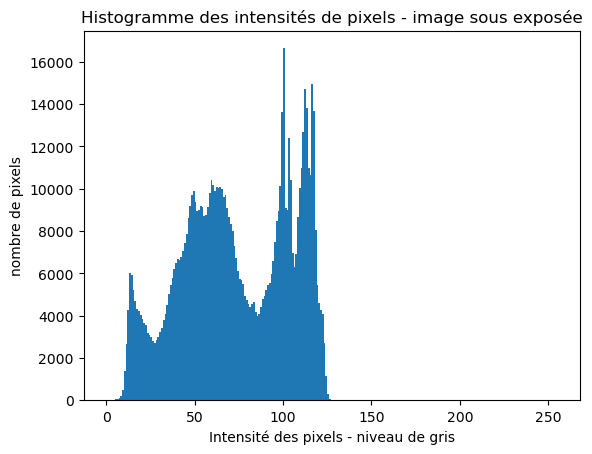

In [29]:
mat = np.array(image_sous_exposee)
display_histo_intensity(mat, "Histogramme des intensités de pixels - image sous exposée")

On voit clairement le décalage vers le noir (0).

Image sur-exposée :

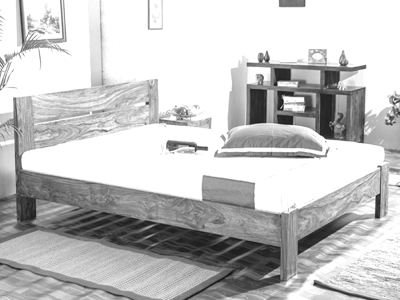

In [32]:
# Créer un objet ImageEnhance pour la luminosité
enhancer = ImageEnhance.Brightness(img)

# Ajuster l'exposition (facteur > 1 augmente, facteur < 1 diminue)
facteur = 1.5  # Par exemple : 1.5 pour augmenter, 0.5 pour réduire
image_sur_exposee = enhancer.enhance(facteur)

# Afficher ou enregistrer l'image modifiée
img_resized = image_sur_exposee.resize((400, 300))  # Spécifiez la largeur et la hauteur
img_resized

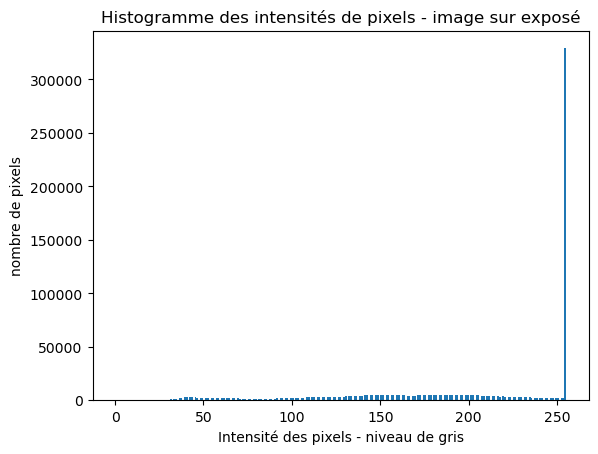

In [33]:
mat = np.array(image_sur_exposee)
display_histo_intensity(mat, "Histogramme des intensités de pixels - image sur exposé")

L'image est dominée par le blanc.

**Etirement de l'histogramme**

l'objectif est d'étendre les valeurs des niveaux de gris de l'image mal exposée, majoritairement répartis dans un sous intervalle (ici proche de 250).

L'étirement d'histogramme se fait avec la fonction "autocontrast" du module ImageOps de Pillow. La fonction autocontrast de la bibliothèque Pillow (PIL) ajuste automatiquement les niveaux de contraste d'une image en étirant les valeurs des pixels pour qu'elles occupent toute la plage possible, de 0 (noir) à 255 (blanc). Cette opération améliore souvent la qualité visuelle d'une image en augmentant son contraste.

On l'applique sur l'image sur-exposée :

In [36]:
# Appliquer autocontrast
image_autocontrastee = ImageOps.autocontrast(image_sur_exposee)

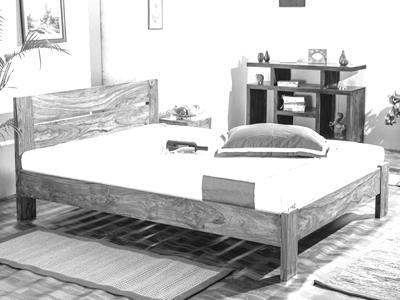

In [37]:
# Afficher ou enregistrer l'image modifiée
img_resized = image_autocontrastee.resize((400, 300))  # Spécifiez la largeur et la hauteur
img_resized

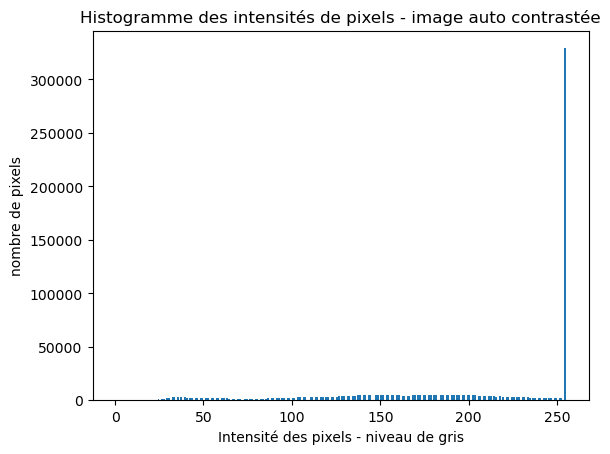

In [38]:
mat = np.array(image_autocontrastee)
display_histo_intensity(mat, "Histogramme des intensités de pixels - image auto contrastée")

L'autocontraste semble avoir échoué.

Raisons pour lesquelles l'autocontraste échoue:
- l'image est déjà concentrée dans la plage supérieure des niveaux de gris (quasiment tous les pixels sont compris entre 200 et 255), l'autocontraste ne peut que recaler ces valeurs sur la plage complète, sans récupérer les détails perdus dans les zones surexposées.

- Une surexposition signifie souvent que les détails dans les hautes lumières (blancs) sont irrécupérables, car les pixels sont "clippés" à la valeur maximale (255). L'autocontraste ne peut pas recréer ces informations perdues.

- Une grande partie de l'image est blanche ou très lumineuse, le recalage des niveaux par autocontraste ne peut pas rééquilibrer l'image correctement.

On l'applique sur l'image sous-exposée :

In [40]:
# Appliquer autocontrast
image_autocontrastee = ImageOps.autocontrast(image_sous_exposee)

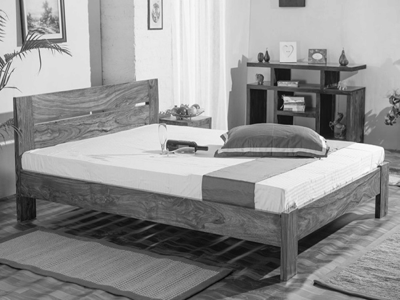

In [41]:
# Afficher ou enregistrer l'image modifiée
img_resized = image_autocontrastee.resize((400, 300))  # Spécifiez la largeur et la hauteur
img_resized

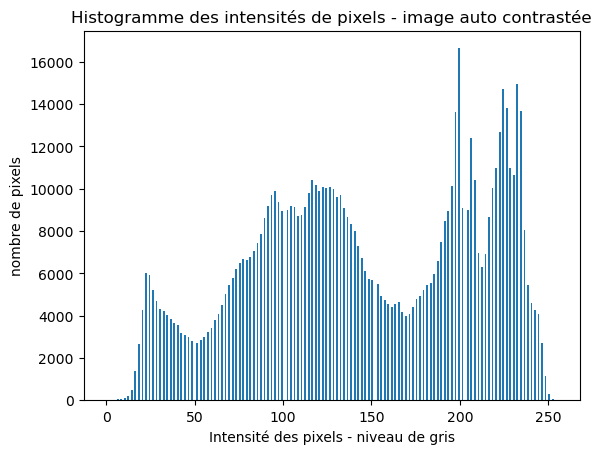

In [42]:
mat = np.array(image_autocontrastee)
display_histo_intensity(mat, "Histogramme des intensités de pixels - image auto contrastée")

On voit ici que l'auto-contraste fonctionne bien.

**Égalisation d’histogrammes**

La deuxième application courante concerne l'amélioration du contraste de l'image.

Le contraste caractérise la répartition de lumière dans une image : plus une image est contrastée, plus la différence de luminosité entre ses zones claires et sombres est important

L'égalisation d'histogrammes est une technique simple permettant de réajuster le contraste d'une image et ainsi de lui redonner du peps ou de l'adoucir.

L'objectif est d'harmoniser la distribution des niveaux de gris de l'image, de sorte que chaque niveau de l'histogramme contienne idéalement le même nombre de pixels. Concrètement, on essaye d'aplatir au maximum l'histogramme original.e.

In [45]:
# Appliquer autocontrast
image_equalize = ImageOps.equalize(img)
mat = np.array(image_equalize)

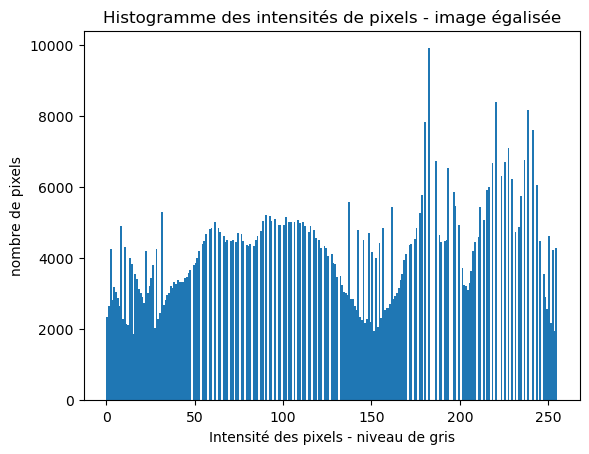

In [46]:
display_histo_intensity(mat, "Histogramme des intensités de pixels - image égalisée")

L'image égalisée est :

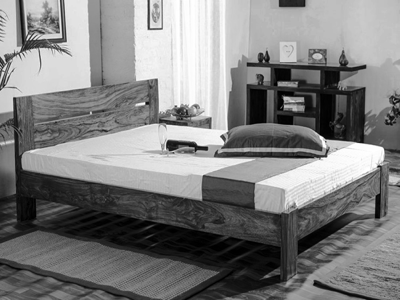

In [48]:
img_equalized = image_equalize.resize((400, 300))  # Spécifiez la largeur et la hauteur
img_equalized

L'image au départ était :

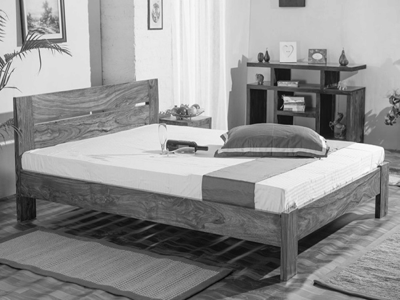

In [50]:
img_resized

L'histogramme cumulé normalisé montre que la fonction de répartition semble être linéaire comme celle de la loi uniforme :

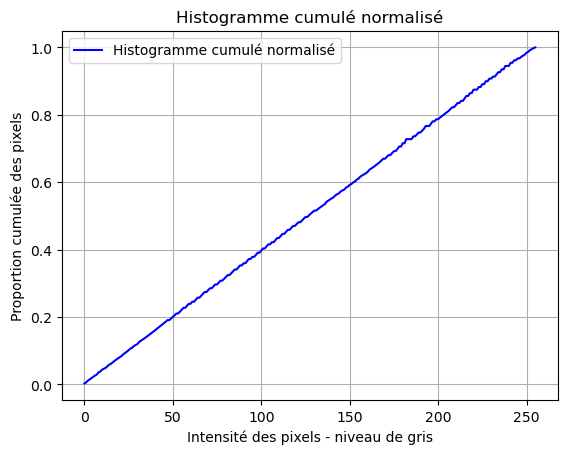

In [52]:
# Convertir en matrice NumPy
mat = np.array(image_equalize)

# Calculer l'histogramme et l'histogramme cumulé
hist, bins = np.histogram(mat.flatten(), bins=range(257), density=True)  # Histogramme normalisé
hist_cumsum = np.cumsum(hist)  # Histogramme cumulé

# Tracer l'histogramme cumulé normalisé
plt.plot(bins[:-1], hist_cumsum, color='blue', label="Histogramme cumulé normalisé")
plt.xlabel("Intensité des pixels - niveau de gris")
plt.ylabel("Proportion cumulée des pixels")
plt.title("Histogramme cumulé normalisé")
plt.legend()
plt.grid()
plt.show()

### 2.3 - Transformations géométriques

Les transformations géométriques modifient la position des pixels dans l'image. Une rotation, une translation ou un changement d'échelle (zoom) en sont des exemples typiques.

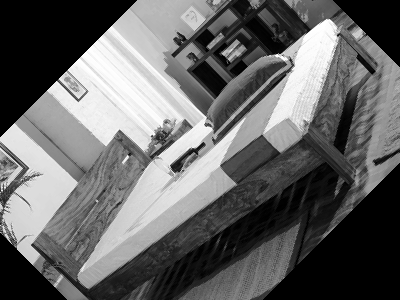

In [54]:
# rotation de 45 degrés
img_equalized.rotate(45, expand=False)

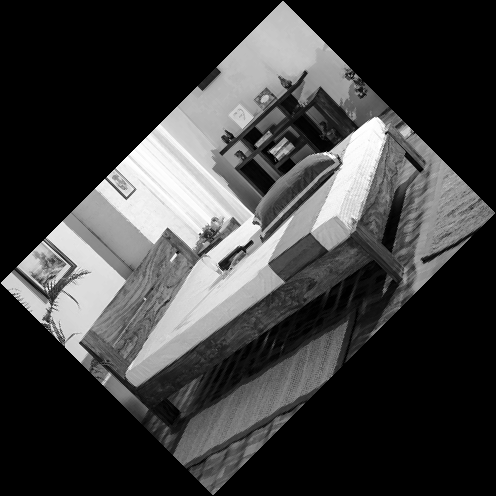

In [55]:
# rotation de 50 degrés
img_equalized.rotate(45, expand=True)

### 2.4 - Filtrage d'une image

La qualité d'une photo peut également être dégradée par du bruit numérique, c'est-à-dire par l'apparition aléatoire de "grains" superflus.

Le bruit peut être vu comme une image constituée de pixels dont les intensités ont été déterminées de manière aléatoire.

Nous pouvons facilement générer du bruit gaussien dans une image. En Python, cela se fait avec la fonction numpy.random.normal, qui simule une variable aléatoire gaussienne : 

Image au départ :

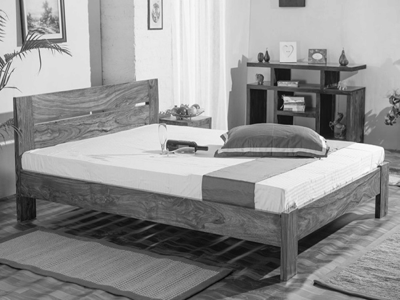

In [58]:
img_resized

Image avec du bruit :

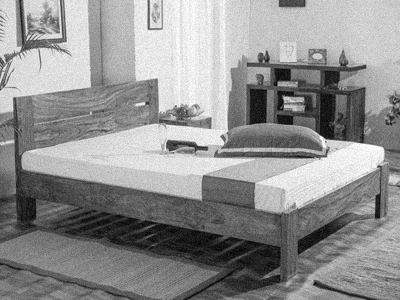

In [60]:
# Récupérer les valeurs de tous les pixels sous forme d'une matrice
mat = np.array(img_resized)

# Générer le bruit gaussien de moyenne nulle et d'écart-type 7 (variance 49)
noise = np.random.normal(0, 7, mat.shape)

# Créer l'image bruitée et l'afficher
noisy_img = Image.fromarray(mat + noise).convert('L')
noisy_img

L'image est moins nette que l'image de départ.

Plusieurs techniques de débruitage (ou lissage) ont été développées afin d'atténuer le bruit dans une image. Le lissage par moyennage désigne la solution la plus intuitive.

Ce qui rend l'image désagréable visuellement, c'est la présence de certains pixels qui ne semblent pas être en cohérence avec les autres éléments de la scène représentée : le bruit leur a donné des valeurs "aberrantes". Dans une image de bonne qualité, un pixel a généralement une intensité relativement similaire à celle de ses voisins.

**Filtre par moyennage**

Le lissage par moyennage consiste alors à remplacer la valeur de chaque pixel par l'intensité moyenne de son voisinage.

En Pillow, le lissage par moyennage est implémenté dans la classe  PIL.ImageFilter.BoxBlur  et il s'applique avec la méthode  PIL.Image.filter.

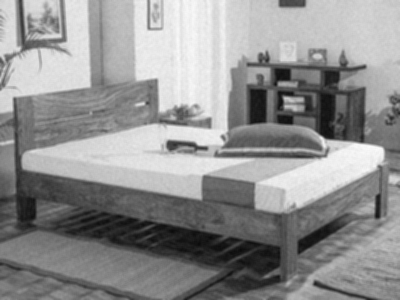

In [62]:
# Appliquer le lissage par moyennage et afficher le résultat
noisy_img.filter(ImageFilter.BoxBlur(1))

Le bruit est bien atténué, mais en contrepartie, l'image est devenue floue – d'où l'appellation BoxBlur (blur = flou en anglais) dans Pillow ! 

En réalité, le lissage par moyennage n'est qu'un exemple de filtre.

**Filtre gaussien**

Un filtre gaussien est un filtre linéaire dont les éléments du noyau de convolution sont déterminés selon la densité d'une loi gaussienne centrée à 2 dimensions.

La normalisation permet d'interpréter ce filtre comme un filtre moyenneur perfectionné : chaque pixel est corrigé avec une moyenne dont les poids ont des valeurs différentes.

La performance du filtre gaussien dépend de la valeur de sa variance : plus l'image est bruitée, plus on doit augmenter la variance, mais plus l'image devient floue.

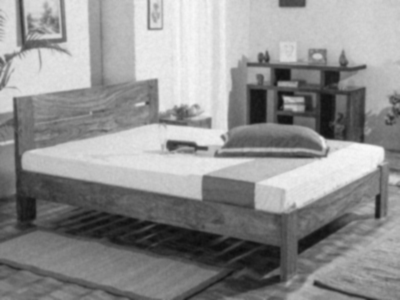

In [101]:
# Appliquer le filtre gaussien et afficher le résultat
noisy_img.filter(ImageFilter.GaussianBlur(1))

**Filtre médian (non-linéaire)**

Bien que les filtres linéaires soient facile à concevoir et à implémenter, notamment avec la propriété de séparabilité, ils ne parviennent pas toujours à éliminer efficacement le bruit, notamment le bruit impulsionnel (par exemple, "poivre et sel").

Ces limitations ont motivé la création des filtres non-linéaires : il s'agit de filtres dont le fonctionnement ne peut être défini comme un produit de convolution.  

Un exemple de filtre non-linéaire est le filtre médian, dont le principe est proche du filtre moyenneur : la valeur de chaque pixel est remplacée par la médiane (et non la moyenne) de son voisinage. 

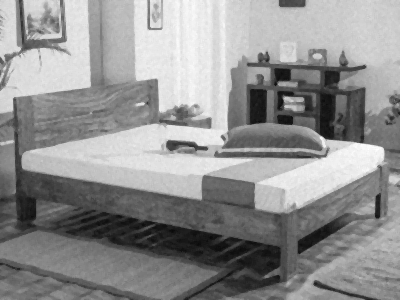

In [108]:
# Appliquer le filtre médian et afficher le résultat
noisy_img.filter(ImageFilter.MedianFilter(size=3))

### 2.5 - Features dans une image

En vision par ordinateur, le terme de (local) features désigne des zones intéressantes de l'image numérique. Ces zones peuvent correspondre à des contours, des points ou des régions d'intérêt. A chaque feature détectée est associé un vecteur, appelé descripteur (feature descriptor ou feature vector), qui, comme son nom l'indique, décrit la zone concernée.

La résolution du problème d'image matching se fait alors en deux étapes:

- Détecter et décrire les features dans chaque image
- Trouver les paires de features qui se correspondent dans les deux images (features matching)

La détection et la description de features constituent la première étape indispensable pour de nombreuses autres tâches en vision par ordinateur, comme la classification d'images